In [1]:
import os
import sys
import random
import warnings
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import Image
from scipy.misc import imfilter
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
%matplotlib inline

########## This code is revised from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 ##########

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3  # training set has 4 channels, but testing set only has 3 channels
BATCH_SIZE = 16
if train_on_local:
    TRAIN_PATH = '/root/dataset/dataScienceBowl2018/stage1_train/'
    TEST_PATH = '/root/dataset/dataScienceBowl2018/stage1_test/'
else:
    TRAIN_PATH = '/home/PNW/wu1114/Documents/dataset/dataScienceBowl2018/stage1_train/'
    TEST_PATH = '/home/PNW/wu1114/Documents/dataset/dataScienceBowl2018/stage1_test/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
# random.seed = seed
# np.random.seed = seed


Using TensorFlow backend.


NameError: name 'train_on_local' is not defined

In [ ]:
def assemble_masks(path):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    for mask_file in next(os.walk(os.path.join(path, 'masks')))[2]:
        mask_ = Image.open(os.path.join(path, 'masks', mask_file))
        mask_ = mask_.resize((IMG_HEIGHT, IMG_WIDTH))
        mask_ = np.asarray(mask_, dtype = np.bool)
        mask = mask | mask_
    mask = np.expand_dims(mask, axis=-1)
    return mask

In [ ]:
def prepare_data(TRAIN_PATH, TEST_PATH):
    '''
    Args:
        file_dir: root file directory
    Returns:
        list of training images, in ndarray, e.g. (560,256,256,4)
        list of training labels, in ndarray, e.g. (560,256,256,1)
    '''
    # get imageId
    train_ids = next(os.walk(TRAIN_PATH))[1]
    test_ids = next(os.walk(TEST_PATH))[1]

    # read training data
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('reading training data...')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids)):
        path = os.path.join(TRAIN_PATH + id_)
        img = Image.open(os.path.join(path, 'images', id_ + '.png')).convert("RGB")
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))
        X_train[n] = img
        Y_train[n] = assemble_masks(path)
    
    # read testing data        
    sizes_test = []
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    print('reading testing data')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(test_ids)):
        path = os.path.join(TEST_PATH, id_, 'images', id_ + '.png')
        img = Image.open(path).convert("RGB")
        sizes_test.append(img.size)
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))
        X_test[n] = img
    print('done')
    return X_train, Y_train, X_test, sizes_test, train_ids, test_ids

In [ ]:
X_train, Y_train, X_test, sizes_test, train_ids, test_ids = prepare_data(TRAIN_PATH, TEST_PATH)

In [ ]:
print('X_train.shape: ' + str(X_train.shape))
print('Y_train.shape: ' + str(Y_train.shape))
print('X_test.shape: ' + str(X_test.shape))
print('length of sizes_test: ' + str(len(sizes_test)))
print(sizes_test[15])

In [ ]:
def get_contour(X, Y):
    '''
    :param images: images, ndarray, e.g.(500,256,256,3)
    :param labels: masks, ndarray, e.g.(500,256,256,1)
    :return:
    images with contour, e.g.(500,256,256,3)
    '''
    num_imgs = X.shape[0]
    contour_images = np.zeros((num_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    contour_labels = np.zeros((num_imgs, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    contours = np.zeros((num_imgs, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('getting contours from masks...')
    sys.stdout.flush()
    for i in tqdm(range(0, num_imgs)):
        x = X[i]
        y = Y[i]
        c = imfilter(np.squeeze(y), "find_edges")
        c = np.expand_dims(c, axis=-1)
        contour_images[i] = (x | c)
        contour_labels[i] = (y | c)
        contours[i] = c
    print('Done!')
    return contour_images, contour_labels, contours

In [ ]:
X_train_contour, Y_train_contour, contour = get_contour(X_train, Y_train)

In [ ]:
# visualize data
def plot_train(X_train, Y_train, index = -1):
    if index == -1:
        index = np.random.randint(images.shape[0])
    image = X_train[index]
    label = Y_train[index]
    print('X_train(index = ' + str(index) + '):')
    plt.imshow(np.squeeze(image))
    plt.show()
    print('Y_train(index = ' + str(index) + '):')
    plt.imshow(np.squeeze(label), cmap ='gray')
    plt.show()
def plot_contour(X_train_contour, Y_train_contour, contour, index = -1):
    if index == -1:
        index = np.random.randint(images.shape[0])
    print('contour(index = ' + str(index) + '):')
    plt.imshow(np.squeeze(contour[index]), cmap ='gray')
    plt.show()
    print('X_train_contour(index = ' + str(index) + '):')
    plt.imshow(np.squeeze(X_train_contour[index]))
    plt.show()
    print('Y_train_contour(index = ' + str(index) + '):')
    plt.imshow(np.squeeze(Y_train_contour[index]), cmap ='gray')
    plt.show()

X_train(index = 641):


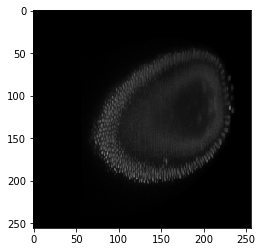

Y_train(index = 641):


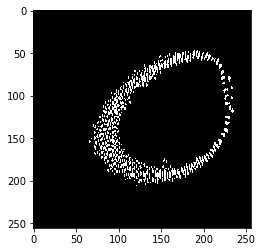

In [9]:
idx = [idx for idx, train_id in enumerate(train_ids) if train_id == 'a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288']
plot_train(X_train, Y_train, 641)

contour(index = 641):


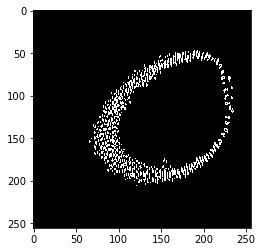

X_train_contour(index = 641):


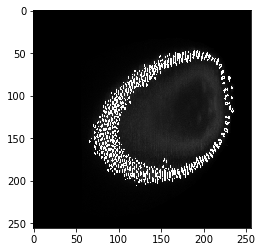

Y_train_contour(index = 641):


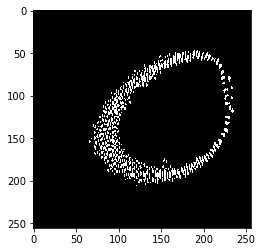

In [10]:
plot_contour(X_train_contour, Y_train_contour, contour, index = 641)

In [13]:
# data augmentation
def generator(xtr, xval, ytr, yval, batch_size):
    # training set augmentation
    data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    # Provide the same seed and keyword arguments to the fit and flow methods
    image_datagen.fit(xtr, augment=True, seed=seed)
    mask_datagen.fit(ytr, augment=True, seed=seed)
    
    image_generator = image_datagen.flow(xtr, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(ytr, batch_size=batch_size, seed=seed)
    train_generator = zip(image_generator, mask_generator)
    
    # testing set augmentation
    val_gen_args = dict()
    image_datagen_val = ImageDataGenerator(**val_gen_args)
    mask_datagen_val = ImageDataGenerator(**val_gen_args)
    # Provide the same seed and keyword arguments to the fit and flow methods
    image_datagen_val.fit(xval,augment=True, seed=seed)
    mask_datagen_val.fit(yval,augment=True, seed=seed)
    image_generator_val = image_datagen.flow(xval, batch_size=batch_size, seed=seed)
    mask_generator_val = mask_datagen.flow(yval, batch_size=batch_size, seed=seed)
    val_generator = zip(image_generator_val, mask_generator_val)

    return train_generator, val_generator

In [14]:
BATCH_SIZE = 16
xtr, xval, ytr, yval = train_test_split(X_train, Y_train, test_size=0.1, random_state=7)
train_generator, val_generator = generator(xtr, xval, ytr, yval, BATCH_SIZE)
print(train_generator)

(16, 256, 256, 3)
(16, 256, 256, 1)


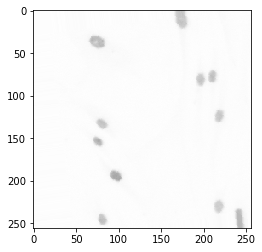

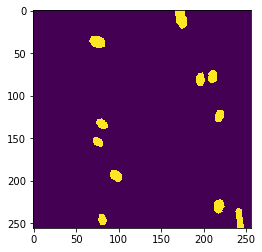

In [22]:
for a,b in train_generator:
    print(a.shape)
    print(b.shape)
    plt.imshow(a[0])
    plt.show()
    plt.imshow(np.squeeze(b[0]))
    plt.show()
    break

In [23]:
def mean_iou(y_true, y_pred):
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [24]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 256, 256, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 16)  448         lambda_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 256, 16)  0           conv2d_1[0][0]                   
___________________________________________________________________________________________

In [28]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=1, 
#                     callbacks=[earlystopper, checkpointer])
model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=1, validation_data=val_generator, 
                    validation_steps=len(xval)/BATCH_SIZE, verbose = 1, callbacks=[earlystopper, checkpointer])

Epoch 1/1
101/100 [==============================] - 420s - loss: 0.1066 - mean_iou: 0.4306 - val_loss: 0.1057 - val_mean_iou: 0.4307


In [29]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-2.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 4s     


In [145]:
# plot prediction
def plot_prediction(preds, preds_t, X, Y, index = -1):
    if index == -1:
        index = np.random.randint(X.shape[0])
    print('image(index = ' + str(index) + '):')
    # print(np.squeeze(X_test[index]))
    plt.imshow(np.squeeze(X[index]))
    plt.show()
    if Y is not None:
        print('label(index = ' + str(index) + '):')
        plt.imshow(np.squeeze(Y[index]))
        plt.show()
    print('prediction: ')
    # print(np.squeeze(preds_test[index]))
    plt.imshow(np.squeeze(preds[index]), cmap = 'gray')
    plt.show()
    print('prediction (threshold>0.5): ')
    # print(np.squeeze(preds_test_t[index]))
    plt.imshow(np.squeeze(preds_t[index]), cmap = 'gray')
    plt.show()

image(index = 446):


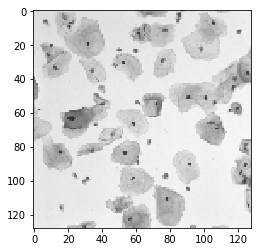

label(index = 446):


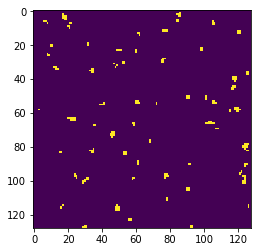

prediction: 


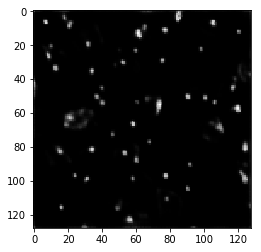

prediction (threshold>0.5): 


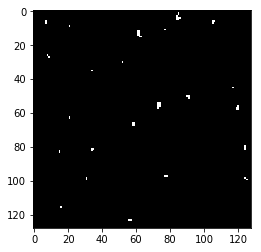

In [146]:
# plot prediction on training set
plot_prediction(preds = preds_train, preds_t = preds_train_t, X = X_train, Y = Y_train)

image(index = 25):


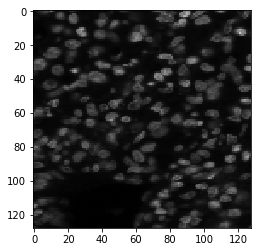

prediction: 


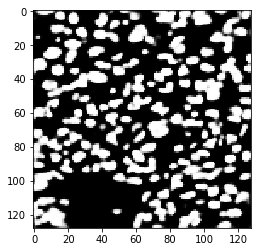

prediction (threshold>0.5): 


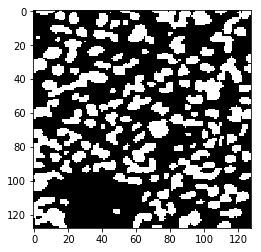

In [147]:
# plot prediction on testing set
plot_prediction(preds = preds_test, preds_t = preds_test_t, X = X_test, Y = None)

X_test(index = 22):


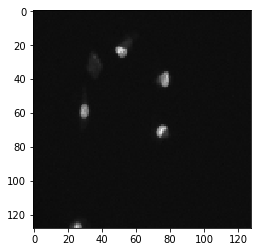

prediction on testing: 


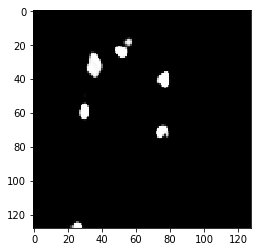

prediction on testing (threshold>0.5): 


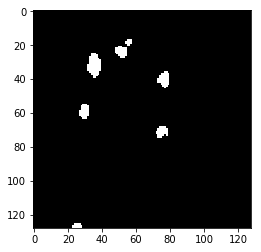

In [148]:
# plot prediction on testing set
index = np.random.randint(X_test.shape[0])
print('X_test(index = ' + str(index) + '):')
# print(np.squeeze(X_test[index]))
plt.imshow(np.squeeze(X_test[index]))
plt.show()
print('prediction on testing: ')
# print(np.squeeze(preds_test[index]))
plt.imshow(np.squeeze(preds_test[index]), cmap = 'gray')
plt.show()
print('prediction on testing (threshold>0.5): ')
# print(np.squeeze(preds_test_t[index]))
plt.imshow(np.squeeze(preds_test_t[index]), cmap = 'gray')
plt.show()

In [44]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [45]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [49]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)